In [1]:
from qutip import *
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

N = 10

times = np.linspace(0.0, 10.0, 401)

psi_list = [basis(2, 1) for i in range(N)]
#psi_list = [basis(2, 0 if i == N // 2 else 1) for i in range(N)]
#psi_list = [basis(2, (i+1) % 2) for i in range(N)]
psi0 = tensor(psi_list)

hx, hy, hz = -0.5, 0.3, 1.6
Jx, Jy, Jz = 0.7, -0.5, -1.2
#hz = [(np.random.uniform(-8.0, 8.0) + 4) / 2 for _ in range(N)] 
gamma = 0.001
alpha = 3

In [2]:
sx_list = []
sy_list = []
sz_list = []
sm_list = []

for n in range(N):
    op_list = [qeye(2) for _ in range(N)]
    
    op_list[n] = sigmax()
    sx_list.append(tensor(op_list))
    
    op_list[n] = sigmay()
    sy_list.append(tensor(op_list))
    
    op_list[n] = sigmaz()
    sz_list.append(tensor(op_list))
    
    op_list[n] = destroy(2)
    sm_list.append(tensor(op_list))

H = 0
for n in range(N):
    H += hx * sx_list[n]
    H += hy * sy_list[n]
    H += hz * sz_list[n]

l = N
for i in range(N):
    for j in range(i+1, min(i+1+l, N)):
        H += Jx / (np.abs(i-j)**alpha) * sx_list[i] * sx_list[j]
        H += Jy / (np.abs(i-j)**alpha) * sy_list[i] * sy_list[j]
        H += Jz / (np.abs(i-j)**alpha) * sz_list[i] * sz_list[j]
    
H.tidyup()

#c_op_list = [np.sqrt(gamma) * sm_list[k] for k in range(N)]

total_sz = sum(sz_list)

#result = mesolve(H, psi0, times, c_op_list, e_ops=sz_list + [total_sz], options={"progress_bar" : "tqdm", "store_states" : True})
result = sesolve(H, psi0, times, e_ops=sz_list + [total_sz] + [H], options={"progress_bar" : "tqdm", "store_states" : True})

  0%|          | 0/400 [00:00<?, ?it/s]

In [1]:
from qutip import *
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

N = 12

times = np.linspace(0.0, 300, 1001)

psi_list = [basis(2, 0) if i < N-1 else basis(2, 1) for i in range(N)]
psi0 = tensor(psi_list)

J = 0.00526
B = -1.0

positions = [[0.0, 0.0, 0.0], [0.47140452079103173, 0.816496580927726, 0.3333333333333333], [0.47140452079103173, -0.816496580927726, 0.3333333333333333],
             [1.4142135623730951, 0.816496580927726, 0.0], [1.4142135623730951, -0.816496580927726, 0.0], [1.885618083164127, 0.0, 0.3333333333333333],
             [2.8284271247461903, 0.0, 0.0], [3.299831645537222, 0.816496580927726, 0.3333333333333333], [3.299831645537222, -0.816496580927726, 0.3333333333333333],
             [4.242640687119286, 0.816496580927726, 0.0], [4.242640687119286, -0.816496580927726, 0.0], [4.714045207910317, 0.0, 0.3333333333333333]]

gamma = 0.001

In [ ]:
sx_list = []
sy_list = []
sz_list = []
sm_list = []

for n in range(N):
    op_list = [qeye(2) for _ in range(N)]
    
    op_list[n] = sigmax()
    sx_list.append(tensor(op_list))
    
    op_list[n] = sigmay()
    sy_list.append(tensor(op_list))
    
    op_list[n] = sigmaz()
    sz_list.append(tensor(op_list))
    
    op_list[n] = destroy(2)
    sm_list.append(tensor(op_list))

args = {}

def Bx_func(t, args):
    return 0 #B * np.sin(t)

def By_func(t, args):
    return 0 #B * np.sin(t)

def Bz_func(t, args):
    return B # * np.cos(t)

H1x = 0
H1y = 0
H1z = 0
for n in range(N):
    H1x += sx_list[n]
    H1y += sy_list[n]
    H1z += sz_list[n]

H1x.tidyup()
H1y.tidyup()
H1z.tidyup()

H2 = 0
for i in range(N):
    for j in range(i+1, N):
        xi, yi, zi = positions[i]
        xj, yj, zj = positions[j]

        dx = xj - xi
        dy = yj - yi
        dz = zj - zi
        
        dr3 = pow(dx * dx + dy * dy + dz * dz, 1.5)

        H2 += J / dr3 * (3.0 * dx * dx - 1.0) * sx_list[i] * sx_list[j]
        H2 += J / dr3 * (3.0 * dy * dy - 1.0) * sy_list[i] * sy_list[j]
        H2 += J / dr3 * (3.0 * dz * dz - 1.0) * sz_list[i] * sz_list[j]

        H2 += J / dr3 * 3.0 * dx * dy * (sx_list[i] * sy_list[j] + sx_list[j] * sy_list[i])
        H2 += J / dr3 * 3.0 * dx * dz * (sx_list[i] * sz_list[j] + sx_list[j] * sz_list[i])
        H2 += J / dr3 * 3.0 * dy * dz * (sy_list[i] * sz_list[j] + sy_list[j] * sz_list[i])

H2.tidyup()

H = []

H.append([H1x, Bx_func])
H.append([H1y, By_func])
H.append([H1z, Bz_func])
H.append(H2)

def Hcurrent(t, args):
    Bx = Bx_func(t, args)
    By = By_func(t, args)
    Bz = Bz_func(t, args)
    return Bx * H1x + By * H1y + Bz * H1z + H2

def H_expect(t, psi):
    H_t = Hcurrent(t, args)
    return expect(H_t, psi)

#c_op_list = [np.sqrt(gamma) * sm_list[k] for k in range(N)]

total_sz = sum(sz_list)

#result = mesolve(H, psi0, times, c_op_list, e_ops=sz_list + [total_sz] + [H_expect], options={"progress_bar" : "tqdm", "store_states" : True}, args=args)
result = sesolve(H, psi0, times, e_ops=sz_list + [total_sz] + [H_expect], options={"progress_bar" : "tqdm", "store_states" : True}, args=args)

In [3]:
result.expect[-1][0]

np.float64(-28.510662550690455)

In [4]:
result.expect[-1][-1]

np.float64(-28.505156923182085)

In [5]:
energy_ground, psi_ground = H.groundstate()

In [5]:
energy_ground, psi_ground = Hcurrent(0, args).groundstate()

In [6]:
energy_ground

np.float64(-29.94106446678936)

In [7]:
psi_ground

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1]], shape=(1024, 1), type='ket', dtype=Dense
Qobj data =
[[-5.36716781e-05+0.00000000e+00j]
 [ 1.13464545e-05+1.21638728e-04j]
 [ 1.19066302e-05+3.01775108e-05j]
 ...
 [-1.53915655e-02+5.38769328e-02j]
 [-1.50866394e-02+8.23658118e-02j]
 [ 4.34470757e-01+8.29574688e-01j]]

In [ ]:
c_op_list = [np.sqrt(gamma) * sm_list[k] for k in range(N)]

corr_zz = np.zeros((len(times), N, N), dtype=np.complex128)

for i in tqdm(range(N), unit="i"):
    for j in range(N):
        corr = correlation_2op_2t(H, psi0, [0], times, c_op_list, sz_list[i], sz_list[j])
        corr_zz[:,i,j] = corr

D = 0.5 * (1 - N**(-1) * np.trace(corr_zz, axis1=1, axis2=2)).real

In [8]:
states = result.states
left_n  = N // 2
keep    = list(range(left_n))

entropy_list = []

for psi_t in states:
    rho_t = ket2dm(psi_t) if psi_t.isket else psi_t

    rho_left = rho_t.ptrace(keep)

    S = entropy_vn(rho_left, base=2)

    entropy_list.append(S)

In [10]:
states = result.states
keep = [1, 5]

mutual_information = []

rho_list = []

for psi_t in states:
    rho_t = ket2dm(psi_t) if psi_t.isket else psi_t

    rho_1 = rho_t.ptrace(keep[0:1])
    rho_2 = rho_t.ptrace(keep[1:])
    rho_12 = rho_t.ptrace(keep)

    rho_list.append(rho_12)

    S1 = entropy_vn(rho_1, base=2)
    S2 = entropy_vn(rho_2, base=2)
    S12 = entropy_vn(rho_12, base=2)

    mutual_information.append(S1+S2-S12)

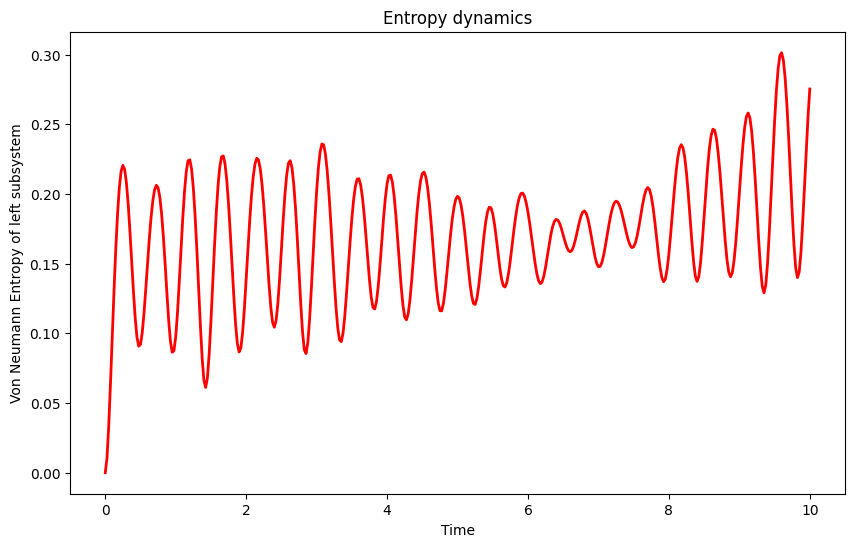

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(times, entropy_list, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Von Neumann Entropy of left subsystem')
plt.title('Entropy dynamics')
plt.show()

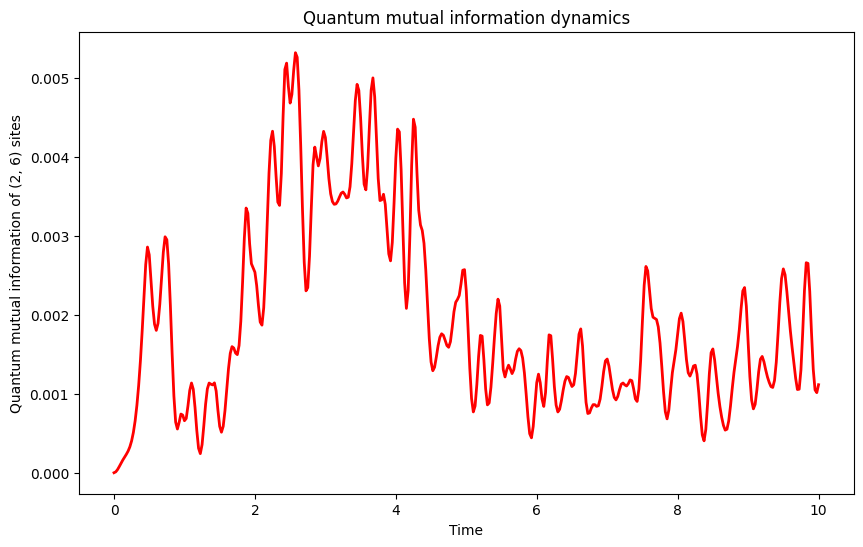

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(times, mutual_information, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(f'Quantum mutual information of ({keep[0]+1}, {keep[1]+1}) sites')
plt.title('Quantum mutual information dynamics')
plt.show()

In [6]:
with open('ExpectedSigmaZ_3DChain.txt', 'w') as file:
    for i in range(len(times)):
        file.write(str(times[i]))
        for n in range(N):
            file.write("\t" + str(result.expect[n][i]))
        file.write("\n")

In [ ]:
with open('VonNeumannEntropy_3DChain.txt', 'w') as file:
    for i in range(len(times)):
        file.write(str(times[i]) + "\t" + str(entropy_list[i]) + "\n")

In [ ]:
with open('MutualInformation_3DChain.txt', 'w') as file:
    for i in range(len(times)):
        file.write(str(times[i]) + "\t" + str(mutual_information[i]) + "\n")

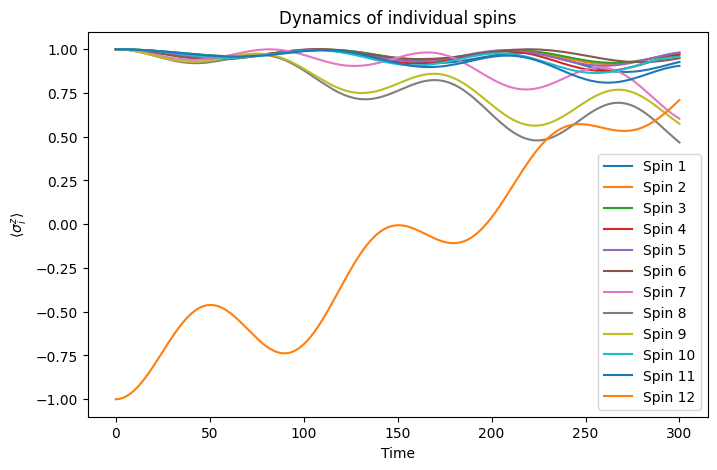

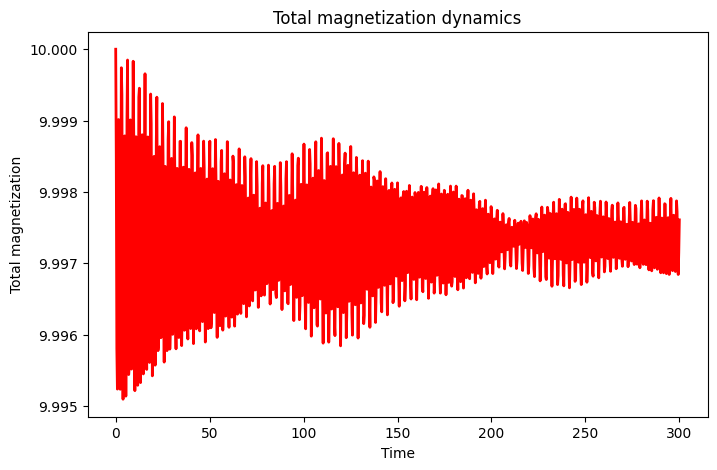

In [5]:
plt.figure(figsize=(8, 5))
for n in range(N):
    plt.plot(times, result.expect[n], label=f"Spin {n+1}")
plt.xlabel('Time')
plt.ylabel(r'$⟨σ^z_i⟩$')
plt.legend()
plt.title('Dynamics of individual spins')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, result.expect[N], 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total magnetization')
plt.title('Total magnetization dynamics')
plt.show()

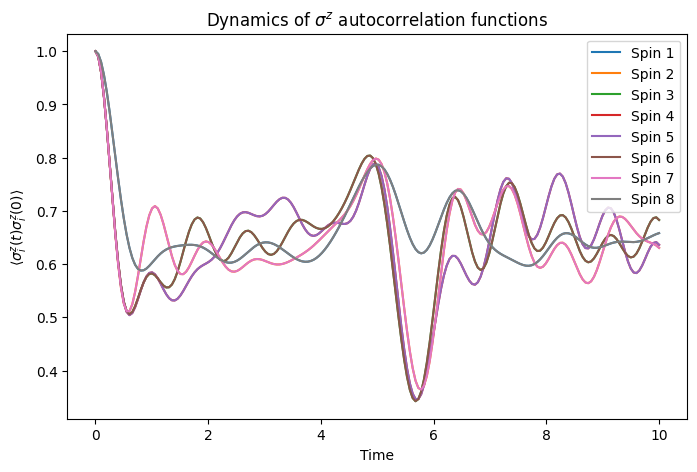

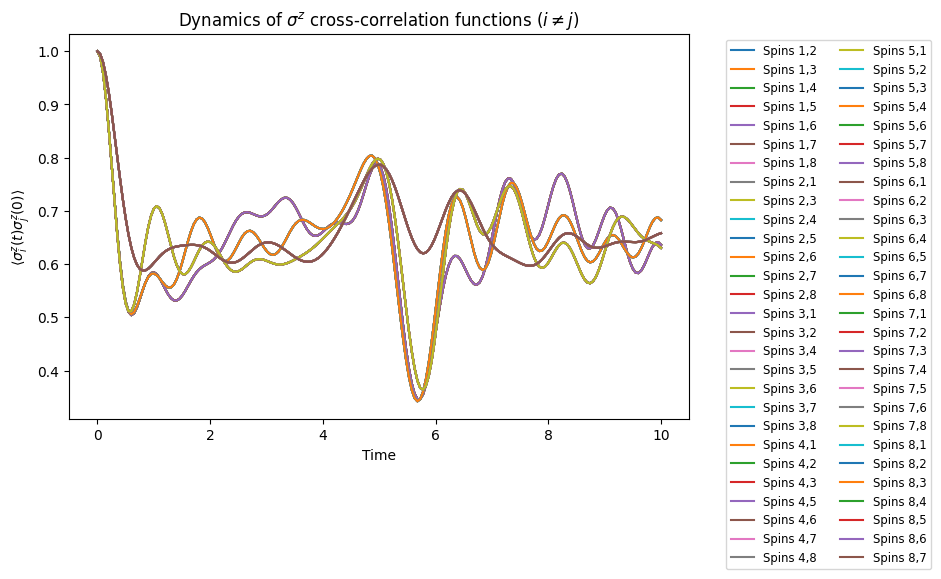

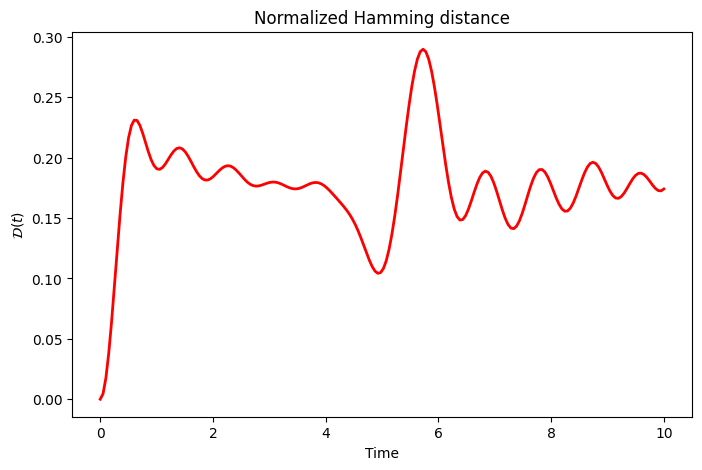

In [43]:
plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(times, np.real(corr_zz[:, i, i]), label=f'Spin {i+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma^z_i(t)\sigma^z_i(0) \rangle$')
plt.legend()
plt.title(r'Dynamics of $\sigma^z$ autocorrelation functions')
plt.show()

plt.figure(figsize=(8, 5))
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(times, np.real(corr_zz[:, i, j]), label=f'Spins {i+1},{j+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma^z_i(t)\sigma^z_j(0) \rangle$')
plt.title(r'Dynamics of $\sigma^z$ cross-correlation functions ($i \neq j$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(times, D, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'$\mathcal{D}(t)$')
plt.title('Normalized Hamming distance')
plt.show()